Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


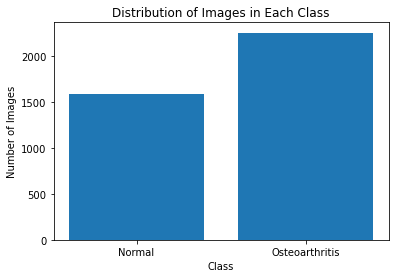

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-23 12:04:43.429237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 12:04:43.429406: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 12:04:43.430960: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 12:04:43.448916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 12:04:43.793118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


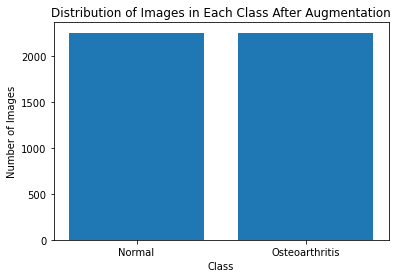

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 500)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 500)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 500 + [1] * 500  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 560
X_test size: 300
X_validation size: 140


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

# CNN+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
X_train = np.array(X_train) / 255.0  # Scale pixel values to [0, 1]
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.4760 - loss: 1.0103 - val_accuracy: 0.5857 - val_loss: 0.6853
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.5287 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.6996
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.5161 - loss: 0.6927 - val_accuracy: 0.4786 - val_loss: 0.6888
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.5282 - loss: 0.6844 - val_accuracy: 0.5857 - val_loss: 0.6708
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5615 - loss: 0.6747 - val_accuracy: 0.5714 - val_loss: 0.6656
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5720 - loss: 0.6781 - val_accuracy: 0.5071 - val_loss: 0.6804
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.6022 - loss: 0.6635 - val_accuracy: 0.4929 - val_loss: 0.6923
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.5986 - loss: 0.6582 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


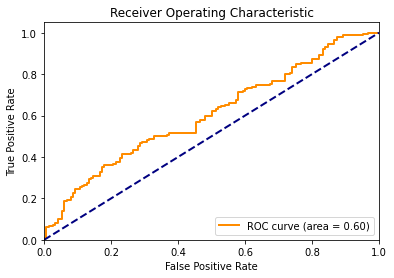

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5672 - loss: 0.6794
Validation Loss: 0.6487576961517334
Validation Accuracy: 0.6000000238418579
Test Loss: 0.6751507917170724
Inference Time (seconds): 0.7122952938079834
Test Accuracy: 0.58
Confusion Matrix:
 [[124  26]
 [100  50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.83      0.66       150
           1       0.66      0.33      0.44       150

    accuracy                           0.58       300
   macro avg       0.61      0.58      0.55       300
weighted avg       0.61      0.58      0.55       300

ROC AUC Score: 0.6048888888888888
Metrics saved successfully


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.6219 - loss: 0.6265 - val_accuracy: 0.5571 - val_loss: 0.6612
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.6549 - loss: 0.6155 - val_accuracy: 0.5714 - val_loss: 0.6592
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.6525 - loss: 0.5878 - val_accuracy: 0.5500 - val_loss: 0.6532
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.6723 - loss: 0.5685 - val_accuracy: 0.5500 - val_loss: 0.7077
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.6527 - loss: 0.5996 - val_accuracy: 0.4857 - val_loss: 0.7318
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.6620 - loss: 0.5612 - val_accuracy: 0.6000 - val_loss: 0.6963
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.6242 - loss: 0.5947 - val_accuracy: 0.5786 - val_loss: 0.6681
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.7078 - loss: 0.5531 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


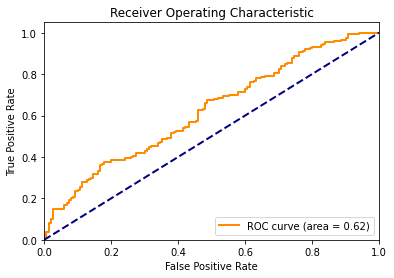

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5327 - loss: 0.6830
Validation Loss: 0.6532304883003235
Validation Accuracy: 0.550000011920929
Test Loss: 0.669107861906911
Inference Time (seconds): 0.7298672199249268
Test Accuracy: 0.56
Confusion Matrix:
 [[87 63]
 [69 81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57       150
           1       0.56      0.54      0.55       150

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

ROC AUC Score: 0.6224444444444445
Metrics saved successfully


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6753 - loss: 0.5771 - val_accuracy: 0.5143 - val_loss: 0.7276
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.6685 - loss: 0.5731 - val_accuracy: 0.5143 - val_loss: 0.6797
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.7075 - loss: 0.5475 - val_accuracy: 0.6000 - val_loss: 0.6657
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.6996 - loss: 0.5576 - val_accuracy: 0.6071 - val_loss: 0.6814
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.7033 - loss: 0.5217 - val_accuracy: 0.5357 - val_loss: 0.7497
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.7200 - loss: 0.5012 - val_accuracy: 0.6071 - val_loss: 0.7607
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.7457 - loss: 0.4970 - val_accuracy: 0.5000 - val_loss: 0.9207
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.7243 - loss: 0.5043 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


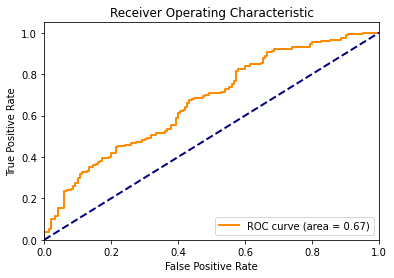

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5937 - loss: 0.6881
Validation Loss: 0.6656942367553711
Validation Accuracy: 0.6000000238418579
Test Loss: 0.6740274231232858
Inference Time (seconds): 0.7482903003692627
Test Accuracy: 0.62
Confusion Matrix:
 [[ 83  67]
 [ 47 103]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59       150
           1       0.61      0.69      0.64       150

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300

ROC AUC Score: 0.667911111111111
Metrics saved successfully


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.6844 - loss: 0.5754 - val_accuracy: 0.5643 - val_loss: 0.6836
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.6893 - loss: 0.5453 - val_accuracy: 0.5071 - val_loss: 0.7717
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.7406 - loss: 0.4991 - val_accuracy: 0.5929 - val_loss: 0.7330
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.7459 - loss: 0.4822 - val_accuracy: 0.6786 - val_loss: 0.7033
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.7967 - loss: 0.4418 - val_accuracy: 0.5857 - val_loss: 0.7866
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.8375 - loss: 0.4411 - val_accuracy: 0.6500 - val_loss: 0.7593
Training Time: 31.416457891464233 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


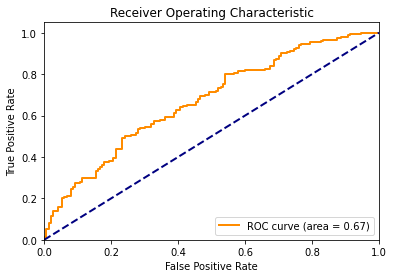

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5470 - loss: 0.7080
Validation Loss: 0.6836243867874146
Validation Accuracy: 0.5642856955528259
Test Loss: 0.681054889227186
Inference Time (seconds): 0.7881548404693604
Test Accuracy: 0.6166666666666667
Confusion Matrix:
 [[99 51]
 [64 86]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.63       150
           1       0.63      0.57      0.60       150

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300

ROC AUC Score: 0.6707555555555555
Metrics saved successfully


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# CNN+Dropout+Dense

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define CNN architecture for RGB images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Change input shape to (224, 224, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step - accuracy: 0.4908 - loss: 2.1642 - val_accuracy: 0.5571 - val_loss: 0.6811
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - accuracy: 0.4999 - loss: 0.6998 - val_accuracy: 0.5786 - val_loss: 0.6855
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.5564 - loss: 0.6870 - val_accuracy: 0.4714 - val_loss: 0.6927
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.5578 - loss: 0.6765 - val_accuracy: 0.5857 - val_loss: 0.6745
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.6059 - loss: 0.6627 - val_accuracy: 0.5000 - val_loss: 0.6856
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.6294 - loss: 0.6509 - val_accuracy: 0.5786 - val_loss: 0.6691
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.5609 - loss: 0.6665 - val_accuracy: 0.6143 - val_loss: 0.6586
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.6348 - loss: 0.6445 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


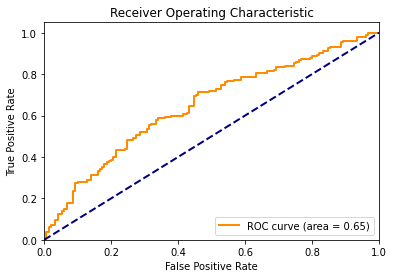

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5542 - loss: 0.6830
Validation Loss: 0.650973379611969
Validation Accuracy: 0.5857142806053162
Test Loss: 0.67500394243747
Inference Time (seconds): 0.8796591758728027
Test Accuracy: 0.5866666666666667
Confusion Matrix:
 [[129  21]
 [103  47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.86      0.68       150
           1       0.69      0.31      0.43       150

    accuracy                           0.59       300
   macro avg       0.62      0.59      0.55       300
weighted avg       0.62      0.59      0.55       300

ROC AUC Score: 0.6467999999999999
Metrics saved successfully


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.6621 - loss: 0.6053 - val_accuracy: 0.5357 - val_loss: 0.8006
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.6216 - loss: 0.6341 - val_accuracy: 0.5929 - val_loss: 0.6623
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.6239 - loss: 0.6174 - val_accuracy: 0.5571 - val_loss: 0.7118
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.6343 - loss: 0.6164 - val_accuracy: 0.5071 - val_loss: 0.6802
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.6687 - loss: 0.6000 - val_accuracy: 0.5214 - val_loss: 0.6917
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.6925 - loss: 0.5682 - val_accuracy: 0.5857 - val_loss: 0.7074
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.6922 - loss: 0.5586 - val_accuracy: 0.6143 - val_loss: 0.6591
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - accuracy: 0.7007 - loss: 0.5590 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


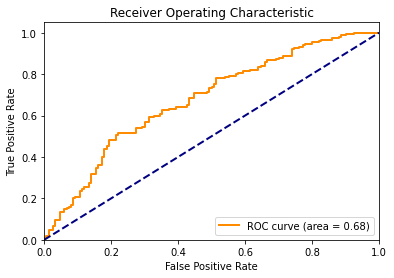

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6119 - loss: 0.6816
Validation Loss: 0.6576584577560425
Validation Accuracy: 0.6285714507102966
Test Loss: 0.6907357538941626
Inference Time (seconds): 0.822735071182251
Test Accuracy: 0.6266666666666667
Confusion Matrix:
 [[123  27]
 [ 85  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.82      0.69       150
           1       0.71      0.43      0.54       150

    accuracy                           0.63       300
   macro avg       0.65      0.63      0.61       300
weighted avg       0.65      0.63      0.61       300

ROC AUC Score: 0.6761333333333333
Metrics saved successfully


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.7154 - loss: 0.5387 - val_accuracy: 0.6214 - val_loss: 0.6633
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.7475 - loss: 0.5081 - val_accuracy: 0.6000 - val_loss: 0.7071
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.7601 - loss: 0.4809 - val_accuracy: 0.5857 - val_loss: 0.7773
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.7922 - loss: 0.4575 - val_accuracy: 0.6500 - val_loss: 0.6867
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.7768 - loss: 0.4377 - val_accuracy: 0.6143 - val_loss: 0.7174
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.7466 - loss: 0.4584 - val_accuracy: 0.6500 - val_loss: 0.6877
Training Time: 49.634530782699585 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


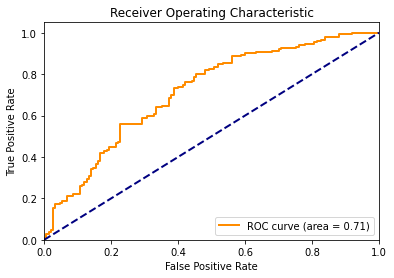

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5982 - loss: 0.6821
Validation Loss: 0.6633373498916626
Validation Accuracy: 0.6214285492897034
Test Loss: 0.6669845317511741
Inference Time (seconds): 0.7661857604980469
Test Accuracy: 0.6266666666666667
Confusion Matrix:
 [[118  32]
 [ 80  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68       150
           1       0.69      0.47      0.56       150

    accuracy                           0.63       300
   macro avg       0.64      0.63      0.62       300
weighted avg       0.64      0.63      0.62       300

ROC AUC Score: 0.7135111111111112
Metrics saved successfully


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.7674 - loss: 0.4961 - val_accuracy: 0.5929 - val_loss: 0.7133
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.7225 - loss: 0.5289 - val_accuracy: 0.5929 - val_loss: 0.7258
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.7621 - loss: 0.4650 - val_accuracy: 0.6214 - val_loss: 0.7582
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.7160 - loss: 0.5029 - val_accuracy: 0.6429 - val_loss: 0.6762
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.7414 - loss: 0.4504 - val_accuracy: 0.6286 - val_loss: 0.7559
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.7660 - loss: 0.4505 - val_accuracy: 0.6857 - val_loss: 0.6885
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.8367 - loss: 0.3748 - val_accuracy: 0.6429 - val_loss: 0.7735
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.8149 - loss: 0.3851 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


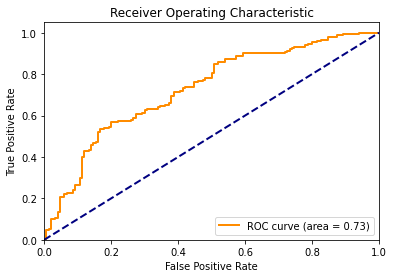

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6166 - loss: 0.6664
Validation Loss: 0.6762116551399231
Validation Accuracy: 0.6428571343421936
Test Loss: 0.6486897322835284
Inference Time (seconds): 0.8054277896881104
Test Accuracy: 0.65
Confusion Matrix:
 [[99 51]
 [54 96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65       150
           1       0.65      0.64      0.65       150

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300

ROC AUC Score: 0.7267111111111111
Metrics saved successfully


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GlobbalAveragePooling+Dense

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling2D
#Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.4973 - loss: 0.6965 - val_accuracy: 0.4500 - val_loss: 0.7013
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.4505 - loss: 0.6979 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.5553 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.4532 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5198 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6964
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5391 - loss: 0.6917 - val_accuracy: 0.4500 - val_loss: 0.6954
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5299 - loss: 0.6927 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


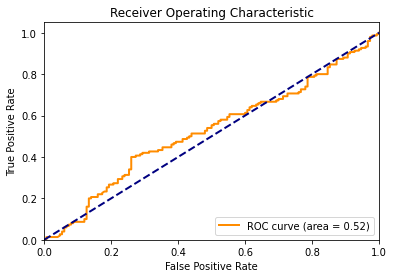

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4512 - loss: 0.6938
Validation Loss: 0.6937475800514221
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6931450949112574
Inference Time (seconds): 0.8720476627349854
Test Accuracy: 0.5
Confusion Matrix:
 [[  0 150]
 [  0 150]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5239111111111111
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [37]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.5561 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.4990 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6954
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.5444 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5288 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5033 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5388 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6965
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5533 - loss: 0.6905 - val_accuracy: 0.4500 - val_loss: 0.6960
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5518 - loss: 0.6910 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


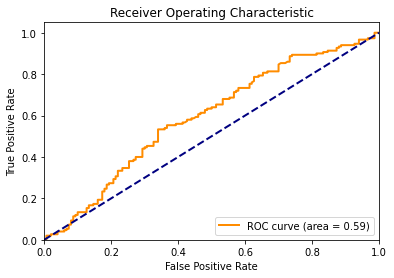

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4512 - loss: 0.6948
Validation Loss: 0.6948756575584412
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6932425747315089
Inference Time (seconds): 0.7404518127441406
Test Accuracy: 0.5
Confusion Matrix:
 [[  0 150]
 [  0 150]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5926888888888889
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [39]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5163 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5162 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6957
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5188 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5162 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6965
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5529 - loss: 0.6913 - val_accuracy: 0.5786 - val_loss: 0.6915
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5104 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6963
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5162 - loss: 0.6921 - val_accuracy: 0.4500 - val_loss: 0.6973
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.4944 - loss: 0.6942 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


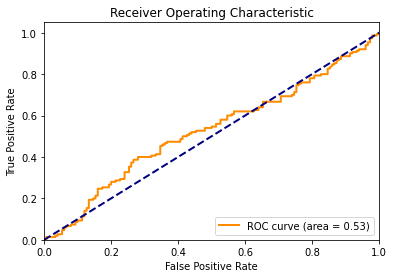

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5622 - loss: 0.6921
Validation Loss: 0.6915197372436523
Validation Accuracy: 0.5785714387893677
Test Loss: 0.6930804340044657
Inference Time (seconds): 0.7429935932159424
Test Accuracy: 0.49
Confusion Matrix:
 [[144   6]
 [147   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.96      0.65       150
           1       0.33      0.02      0.04       150

    accuracy                           0.49       300
   macro avg       0.41      0.49      0.35       300
weighted avg       0.41      0.49      0.35       300

ROC AUC Score: 0.5250444444444444
Metrics saved successfully


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5335 - loss: 0.6919 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5166 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6979
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5034 - loss: 0.6942 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5109 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6963
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5158 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6957
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5118 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5153 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.5274 - loss: 0.6909 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


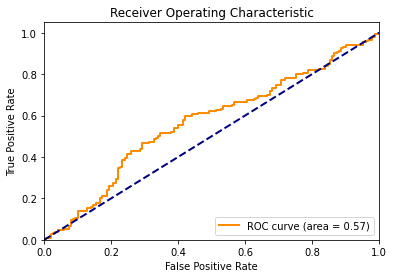

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5058 - loss: 0.6932
Validation Loss: 0.6832835078239441
Validation Accuracy: 0.5357142686843872
Test Loss: 0.6870734077692032
Inference Time (seconds): 0.7427105903625488
Test Accuracy: 0.5633333333333334
Confusion Matrix:
 [[76 74]
 [57 93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54       150
           1       0.56      0.62      0.59       150

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

ROC AUC Score: 0.5664888888888888
Metrics saved successfully


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Conv2D+GlobalAveragePooling+Dropout+Dense

In [43]:
# Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 850ms/step - accuracy: 0.5140 - loss: 0.7020 - val_accuracy: 0.5500 - val_loss: 0.6907
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 832ms/step - accuracy: 0.4821 - loss: 0.6939 - val_accuracy: 0.5857 - val_loss: 0.6929
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 849ms/step - accuracy: 0.5215 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6989
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 835ms/step - accuracy: 0.5316 - loss: 0.6915 - val_accuracy: 0.4500 - val_loss: 0.7011
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 844ms/step - accuracy: 0.5244 - loss: 0.6935 - val_accuracy: 0.4357 - val_loss: 0.6921
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - accuracy: 0.5062 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.7103
Training Time: 91.5407292842865 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


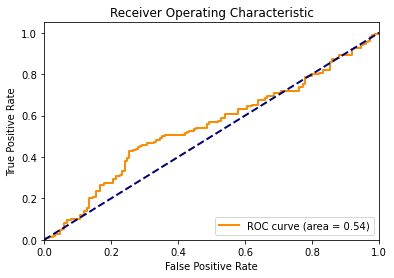

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5488 - loss: 0.6913
Validation Loss: 0.6907354593276978
Validation Accuracy: 0.550000011920929
Test Loss: 0.6930525137980779
Inference Time (seconds): 1.86159348487854
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5448888888888889
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [46]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 851ms/step - accuracy: 0.4955 - loss: 0.6944 - val_accuracy: 0.4500 - val_loss: 0.6962
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 840ms/step - accuracy: 0.4582 - loss: 0.6988 - val_accuracy: 0.4500 - val_loss: 0.6995
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 835ms/step - accuracy: 0.4810 - loss: 0.6963 - val_accuracy: 0.4500 - val_loss: 0.6996
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 843ms/step - accuracy: 0.4835 - loss: 0.6953 - val_accuracy: 0.4500 - val_loss: 0.6982
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 835ms/step - accuracy: 0.4702 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.7007
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 837ms/step - accuracy: 0.5248 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step - accuracy: 0.4962 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.7006
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 823ms/step - accuracy: 0.4911 - loss: 0.6962 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step


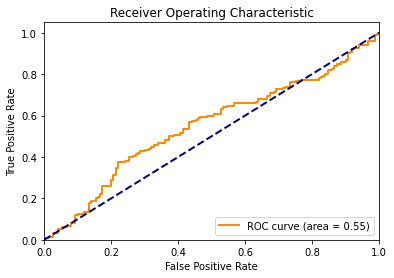

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.5447 - loss: 0.6885
Validation Loss: 0.681155800819397
Validation Accuracy: 0.5571428537368774
Test Loss: 0.687745931148529
Inference Time (seconds): 1.8313157558441162
Test Accuracy: 0.5533333333333333
Confusion Matrix:
 [[96 54]
 [80 70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.64      0.59       150
           1       0.56      0.47      0.51       150

    accuracy                           0.55       300
   macro avg       0.55      0.55      0.55       300
weighted avg       0.55      0.55      0.55       300

ROC AUC Score: 0.5485333333333333
Metrics saved successfully


In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 834ms/step - accuracy: 0.5165 - loss: 0.6925 - val_accuracy: 0.6000 - val_loss: 0.6817
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 830ms/step - accuracy: 0.5097 - loss: 0.6925 - val_accuracy: 0.5214 - val_loss: 0.6883
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step - accuracy: 0.5306 - loss: 0.6900 - val_accuracy: 0.4929 - val_loss: 0.6893
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 845ms/step - accuracy: 0.4893 - loss: 0.6933 - val_accuracy: 0.5429 - val_loss: 0.6867
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 839ms/step - accuracy: 0.5543 - loss: 0.6889 - val_accuracy: 0.5429 - val_loss: 0.6860
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 833ms/step - accuracy: 0.5266 - loss: 0.6886 - val_accuracy: 0.5214 - val_loss: 0.6876
Training Time: 90.3288471698761 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


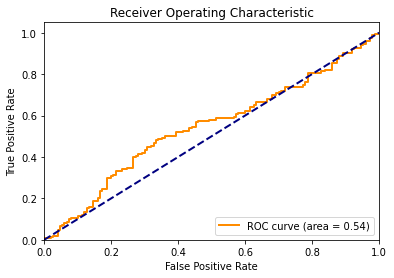

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5759 - loss: 0.6865
Validation Loss: 0.6816574931144714
Validation Accuracy: 0.6000000238418579
Test Loss: 0.6901430284976959
Inference Time (seconds): 1.809741735458374
Test Accuracy: 0.5533333333333333
Confusion Matrix:
 [[122  28]
 [106  44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.81      0.65       150
           1       0.61      0.29      0.40       150

    accuracy                           0.55       300
   macro avg       0.57      0.55      0.52       300
weighted avg       0.57      0.55      0.52       300

ROC AUC Score: 0.5423555555555556
Metrics saved successfully


In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [50]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 848ms/step - accuracy: 0.5292 - loss: 0.6915 - val_accuracy: 0.5714 - val_loss: 0.6851
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 840ms/step - accuracy: 0.5299 - loss: 0.6896 - val_accuracy: 0.4786 - val_loss: 0.6877
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 843ms/step - accuracy: 0.5075 - loss: 0.6936 - val_accuracy: 0.5429 - val_loss: 0.6852
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - accuracy: 0.5145 - loss: 0.6863 - val_accuracy: 0.5071 - val_loss: 0.6877
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 851ms/step - accuracy: 0.5213 - loss: 0.6874 - val_accuracy: 0.5286 - val_loss: 0.6874
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 850ms/step - accuracy: 0.5479 - loss: 0.6898 - val_accuracy: 0.5643 - val_loss: 0.6826
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 890ms/step - accuracy: 0.5505 - loss: 0.6873 - val_accuracy: 0.5286 - val_loss: 0.6833
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 831ms/step - accuracy: 0.5502 - loss: 0.6922 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step


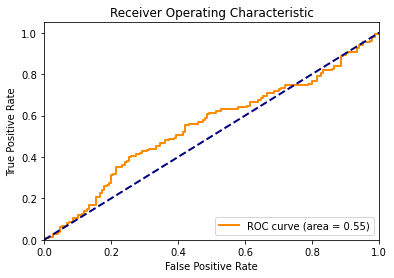

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5449 - loss: 0.6887
Validation Loss: 0.6826111078262329
Validation Accuracy: 0.5642856955528259
Test Loss: 0.6878640364607175
Inference Time (seconds): 1.7950413227081299
Test Accuracy: 0.56
Confusion Matrix:
 [[103  47]
 [ 85  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.69      0.61       150
           1       0.58      0.43      0.50       150

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.56      0.56      0.55       300

ROC AUC Score: 0.546711111111111
Metrics saved successfully


In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+LSTM+Dense

In [53]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (224, 224, 3)

# Define the CNN base model
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Define the LSTM layer
reshape = Reshape((1, -1))(flatten)
lstm = LSTM(128)(reshape)

# Define the dense layers for classification
dense1 = Dense(64, activation='relu')(lstm)
output_layer = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 186624)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    95,617,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,645,249 (364.86 MB)

 Trainable params: 95,645,249 (364.86 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 742ms/step - accuracy: 0.4931 - loss: 0.8126 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 735ms/step - accuracy: 0.4853 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.7021
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 735ms/step - accuracy: 0.5291 - loss: 0.6917 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 731ms/step - accuracy: 0.5008 - loss: 0.6945 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 730ms/step - accuracy: 0.5086 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6970
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 748ms/step - accuracy: 0.4843 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 750ms/step - accuracy: 0.5268 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6972
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 731ms/step - accuracy: 0.4834 - loss: 0.6956 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


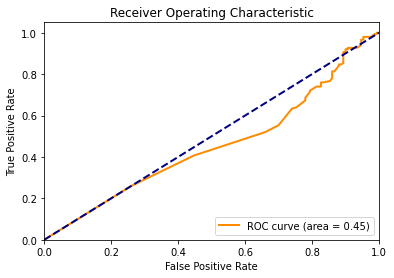

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5488 - loss: 0.6896
Validation Loss: 0.6892067193984985
Validation Accuracy: 0.550000011920929
Test Loss: 0.6942161693175634
Inference Time (seconds): 0.894904375076294
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.45488888888888895
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [56]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 736ms/step - accuracy: 0.4829 - loss: 0.6964 - val_accuracy: 0.4500 - val_loss: 0.7022
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 728ms/step - accuracy: 0.5138 - loss: 0.6971 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 730ms/step - accuracy: 0.4985 - loss: 0.6957 - val_accuracy: 0.4500 - val_loss: 0.7004
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 722ms/step - accuracy: 0.5196 - loss: 0.6923 - val_accuracy: 0.4500 - val_loss: 0.6958
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 727ms/step - accuracy: 0.5337 - loss: 0.7019 - val_accuracy: 0.5500 - val_loss: 0.6874
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.4828 - loss: 0.6999 - val_accuracy: 0.4500 - val_loss: 0.6976
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.5429 - loss: 0.6937 - val_accuracy: 0.5500 - val_loss: 0.6874
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.5038 - loss: 0.6966 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


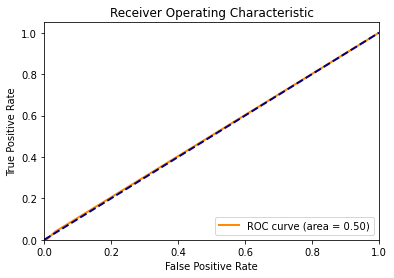

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5488 - loss: 0.6881
Validation Loss: 0.6873795986175537
Validation Accuracy: 0.550000011920929
Test Loss: 0.6975322369734446
Inference Time (seconds): 0.7633318901062012
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5032000000000001
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [58]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 734ms/step - accuracy: 0.4594 - loss: 0.7050 - val_accuracy: 0.5500 - val_loss: 0.6883
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 724ms/step - accuracy: 0.5019 - loss: 0.7008 - val_accuracy: 0.4500 - val_loss: 0.7095
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.5025 - loss: 0.7006 - val_accuracy: 0.5500 - val_loss: 0.6909
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 721ms/step - accuracy: 0.5002 - loss: 0.6961 - val_accuracy: 0.5500 - val_loss: 0.6889
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.4995 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.7100
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 724ms/step - accuracy: 0.4678 - loss: 0.7034 - val_accuracy: 0.4500 - val_loss: 0.7014
Training Time: 78.71568775177002 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


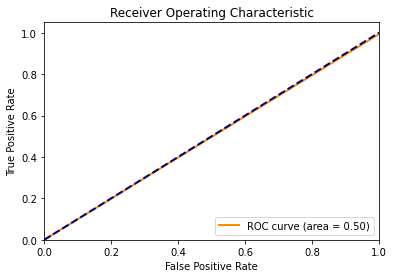

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5488 - loss: 0.6888
Validation Loss: 0.6883033514022827
Validation Accuracy: 0.550000011920929
Test Loss: 0.6951330902179083
Inference Time (seconds): 0.7590687274932861
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.49666666666666665
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [60]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 733ms/step - accuracy: 0.5001 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.7002
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.5664 - loss: 0.6906 - val_accuracy: 0.5500 - val_loss: 0.6873
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.4940 - loss: 0.6986 - val_accuracy: 0.4500 - val_loss: 0.7150
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.4511 - loss: 0.7047 - val_accuracy: 0.4500 - val_loss: 0.7044
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 723ms/step - accuracy: 0.5049 - loss: 0.6962 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 723ms/step - accuracy: 0.5335 - loss: 0.6955 - val_accuracy: 0.5500 - val_loss: 0.6884
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.4999 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.7002
Training Time: 91.77619194984436 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


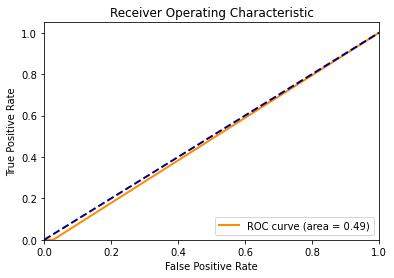

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5488 - loss: 0.6882
Validation Loss: 0.6872748136520386
Validation Accuracy: 0.550000011920929
Test Loss: 0.6994728449980417
Inference Time (seconds): 0.7686033248901367
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.4866666666666667
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GRU+Dense

In [63]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, GRU, Dense
from tensorflow.keras.models import Sequential

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(256, (3, 3), activation='relu'),  # Convolutional layer with 256 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to flatten the output of the convolutional layers
    Reshape((1, -1)),  # Reshape to 3D tensor for GRU
    GRU(128),  # GRU layer with 128 units
    Dense(1, activation='sigmoid')  # Dense layer for binary classification
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 36864)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │    14,205,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,594,241 (55.67 MB)

 Trainable params: 14,594,241 (55.67 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.5491 - loss: 1.0242 - val_accuracy: 0.5500 - val_loss: 0.6835
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.4790 - loss: 0.7099 - val_accuracy: 0.5500 - val_loss: 0.6867
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.5071 - loss: 0.7024 - val_accuracy: 0.4500 - val_loss: 0.7025
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5001 - loss: 0.6947 - val_accuracy: 0.4500 - val_loss: 0.7032
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.5333 - loss: 0.6947 - val_accuracy: 0.4500 - val_loss: 0.6916
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5227 - loss: 0.6859 - val_accuracy: 0.5500 - val_loss: 0.6902
Training Time: 36.98476767539978 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


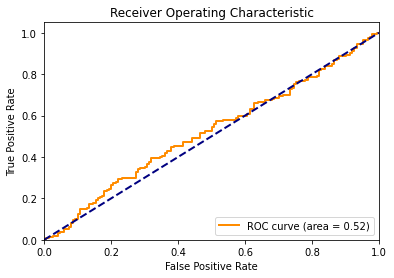

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5488 - loss: 0.6897
Validation Loss: 0.683522641658783
Validation Accuracy: 0.550000011920929
Test Loss: 0.7090056384603183
Inference Time (seconds): 0.9967362880706787
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5197777777777778
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [66]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.4551 - loss: 0.7059 - val_accuracy: 0.5500 - val_loss: 0.6846
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.5578 - loss: 0.6998 - val_accuracy: 0.5500 - val_loss: 0.6827
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.5343 - loss: 0.6974 - val_accuracy: 0.4643 - val_loss: 0.6930
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5500 - loss: 0.6775 - val_accuracy: 0.5143 - val_loss: 0.6927
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.5224 - loss: 0.6740 - val_accuracy: 0.5714 - val_loss: 0.6745
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5759 - loss: 0.6730 - val_accuracy: 0.5500 - val_loss: 0.6908
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5477 - loss: 0.6653 - val_accuracy: 0.5571 - val_loss: 0.6652
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5985 - loss: 0.6512 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


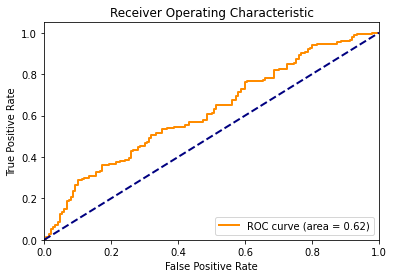

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5256 - loss: 0.6853
Validation Loss: 0.6652273535728455
Validation Accuracy: 0.5571428537368774
Test Loss: 0.678394489834706
Inference Time (seconds): 0.8918743133544922
Test Accuracy: 0.5833333333333334
Confusion Matrix:
 [[129  21]
 [104  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.86      0.67       150
           1       0.69      0.31      0.42       150

    accuracy                           0.58       300
   macro avg       0.62      0.58      0.55       300
weighted avg       0.62      0.58      0.55       300

ROC AUC Score: 0.6180444444444445
Metrics saved successfully


In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [68]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.5856 - loss: 0.6644 - val_accuracy: 0.5929 - val_loss: 0.6899
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.6132 - loss: 0.6583 - val_accuracy: 0.5500 - val_loss: 0.7018
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.5913 - loss: 0.6351 - val_accuracy: 0.4500 - val_loss: 0.7269
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.4976 - loss: 0.6852 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.4777 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.4979 - loss: 0.6919 - val_accuracy: 0.4500 - val_loss: 0.6936
Training Time: 37.54769253730774 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


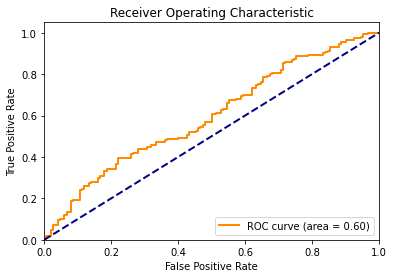

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5687 - loss: 0.7081
Validation Loss: 0.6899069547653198
Validation Accuracy: 0.5928571224212646
Test Loss: 0.682404517158866
Inference Time (seconds): 0.8796062469482422
Test Accuracy: 0.5433333333333333
Confusion Matrix:
 [[68 82]
 [55 95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.50       150
           1       0.54      0.63      0.58       150

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.54       300
weighted avg       0.54      0.54      0.54       300

ROC AUC Score: 0.596
Metrics saved successfully


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [70]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.5821 - loss: 0.6638 - val_accuracy: 0.5429 - val_loss: 0.6777
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.6352 - loss: 0.6355 - val_accuracy: 0.5214 - val_loss: 0.7235
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.5959 - loss: 0.6556 - val_accuracy: 0.4571 - val_loss: 0.6867
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.5439 - loss: 0.6888 - val_accuracy: 0.5714 - val_loss: 0.6943
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.5112 - loss: 0.6887 - val_accuracy: 0.5857 - val_loss: 0.7169
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.6240 - loss: 0.6766 - val_accuracy: 0.4786 - val_loss: 0.7672
Training Time: 37.35054969787598 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


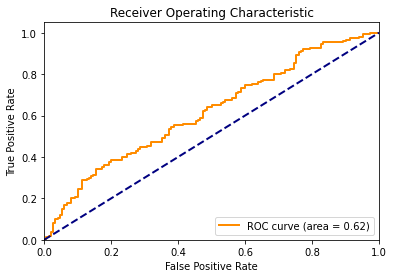

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5269 - loss: 0.7017
Validation Loss: 0.6776994466781616
Validation Accuracy: 0.5428571701049805
Test Loss: 0.6756915379067262
Inference Time (seconds): 0.8819046020507812
Test Accuracy: 0.5766666666666667
Confusion Matrix:
 [[110  40]
 [ 87  63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63       150
           1       0.61      0.42      0.50       150

    accuracy                           0.58       300
   macro avg       0.59      0.58      0.57       300
weighted avg       0.59      0.58      0.57       300

ROC AUC Score: 0.616311111111111
Metrics saved successfully


In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Attention Mechanism+Dense

In [73]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply
from tensorflow.keras.models import Model

# Define the custom CNN architecture with attention mechanism
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
attention_probs = Dense(np.prod(x.shape[1:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
x = Dense(1, activation='sigmoid')(attention_mul)

# Create the model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 222, 222,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 111, 111,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_29… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 54, 54,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 26, 26,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 86528)     │          0 │ max_pooling2d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │ 22,151,424 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │    131,584 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_probs     │ (None, 512)       │    262,656 │ dense_16[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 512)       │          0 │ dense_16[0][0],   │
│                     │                   │            │ attention_probs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        513 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,639,425 (86.36 MB)

 Trainable params: 22,639,425 (86.36 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.4974 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5277 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.4893 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5007 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6936
Training Time: 36.634180545806885 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


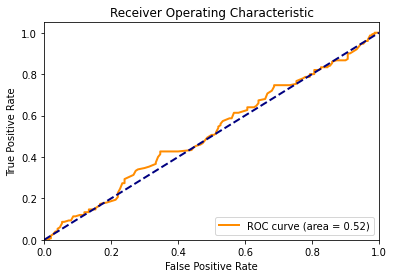

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5488 - loss: 0.6930
Validation Loss: 0.6930341720581055
Validation Accuracy: 0.550000011920929
Test Loss: 0.693147655526797
Inference Time (seconds): 0.8187894821166992
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.5161555555555556
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [76]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.4901 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5207 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.5201 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.5146 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6924
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5211 - loss: 0.6923 - val_accuracy: 0.4500 - val_loss: 0.6901
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5078 - loss: 0.6881 - val_accuracy: 0.4643 - val_loss: 0.6816
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5248 - loss: 0.6710 - val_accuracy: 0.4643 - val_loss: 0.6894
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.5566 - loss: 0.6838 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


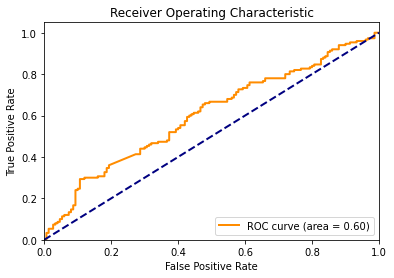

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5381 - loss: 0.6850
Validation Loss: 0.677239716053009
Validation Accuracy: 0.5571428537368774
Test Loss: 0.6874531916280587
Inference Time (seconds): 0.7842276096343994
Test Accuracy: 0.5633333333333334
Confusion Matrix:
 [[107  43]
 [ 88  62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.71      0.62       150
           1       0.59      0.41      0.49       150

    accuracy                           0.56       300
   macro avg       0.57      0.56      0.55       300
weighted avg       0.57      0.56      0.55       300

ROC AUC Score: 0.6022222222222222
Metrics saved successfully


In [77]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [78]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.5924 - loss: 0.6596 - val_accuracy: 0.5571 - val_loss: 0.6725
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5849 - loss: 0.6586 - val_accuracy: 0.5571 - val_loss: 0.6800
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5928 - loss: 0.6540 - val_accuracy: 0.5214 - val_loss: 0.6818
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5579 - loss: 0.6737 - val_accuracy: 0.5214 - val_loss: 0.6845
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.5808 - loss: 0.6735 - val_accuracy: 0.5500 - val_loss: 0.6846
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.5764 - loss: 0.6712 - val_accuracy: 0.5714 - val_loss: 0.6910
Training Time: 36.805147647857666 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


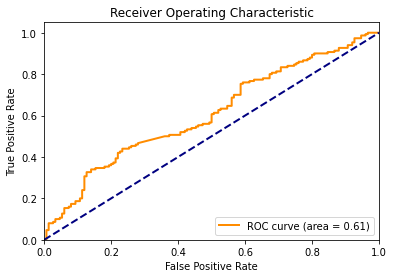

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5386 - loss: 0.6854
Validation Loss: 0.6725307106971741
Validation Accuracy: 0.5571428537368774
Test Loss: 0.6725012357532978
Inference Time (seconds): 0.780247688293457
Test Accuracy: 0.5633333333333334
Confusion Matrix:
 [[94 56]
 [75 75]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.63      0.59       150
           1       0.57      0.50      0.53       150

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

ROC AUC Score: 0.6078666666666667
Metrics saved successfully


In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [80]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.5665 - loss: 0.6598 - val_accuracy: 0.5786 - val_loss: 0.6744
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5740 - loss: 0.6495 - val_accuracy: 0.5357 - val_loss: 0.7036
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5731 - loss: 0.6571 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.6080 - loss: 0.6530 - val_accuracy: 0.5357 - val_loss: 0.6861
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.6181 - loss: 0.6484 - val_accuracy: 0.5429 - val_loss: 0.6825
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.5774 - loss: 0.6491 - val_accuracy: 0.5714 - val_loss: 0.6609
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.6122 - loss: 0.6385 - val_accuracy: 0.5357 - val_loss: 0.6701
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5958 - loss: 0.6341 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


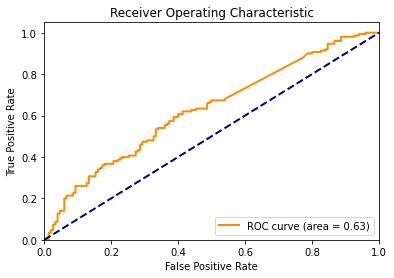

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5329 - loss: 0.6700
Validation Loss: 0.6457761526107788
Validation Accuracy: 0.5714285969734192
Test Loss: 0.6762089923990424
Inference Time (seconds): 0.7860941886901855
Test Accuracy: 0.5933333333333334
Confusion Matrix:
 [[123  27]
 [ 95  55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.82      0.67       150
           1       0.67      0.37      0.47       150

    accuracy                           0.59       300
   macro avg       0.62      0.59      0.57       300
weighted avg       0.62      0.59      0.57       300

ROC AUC Score: 0.6274444444444445
Metrics saved successfully


In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Capsule Network+Dense

In [83]:
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Reshape, Dense
from tensorflow.keras.models import Model

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j

# Define your custom CNN architecture
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((-1, 128))(x)  # Reshape to 3D tensor for Capsule Network
capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
capsule = Flatten()(capsule)  # Flatten the output
output = Dense(1, activation='sigmoid')(capsule)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 160)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,601 (42.68 MB)

 Trainable params: 11,189,601 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.5320 - loss: 0.7072 - val_accuracy: 0.5500 - val_loss: 0.6889
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.4730 - loss: 0.6957 - val_accuracy: 0.4500 - val_loss: 0.6978
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.4625 - loss: 0.6948 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.5135 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.5424 - loss: 0.6900 - val_accuracy: 0.5071 - val_loss: 0.6922
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5275 - loss: 0.6932 - val_accuracy: 0.4643 - val_loss: 0.6932
Training Time: 30.380175590515137 seconds


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


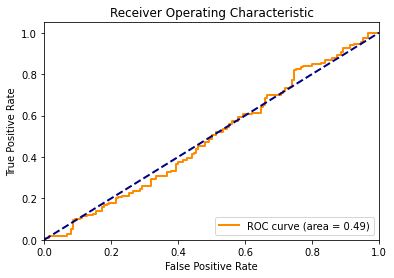

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5488 - loss: 0.6894
Validation Loss: 0.6889280080795288
Validation Accuracy: 0.550000011920929
Test Loss: 0.6941825097799301
Inference Time (seconds): 0.8434250354766846
Test Accuracy: 0.5
Confusion Matrix:
 [[150   0]
 [150   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

ROC AUC Score: 0.4937333333333333
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [86]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.5144 - loss: 0.6919 - val_accuracy: 0.4500 - val_loss: 0.7020
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.5142 - loss: 0.6939 - val_accuracy: 0.5714 - val_loss: 0.6910
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.4769 - loss: 0.6922 - val_accuracy: 0.5071 - val_loss: 0.6917
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.5577 - loss: 0.6909 - val_accuracy: 0.4571 - val_loss: 0.6920
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5182 - loss: 0.6909 - val_accuracy: 0.5429 - val_loss: 0.6882
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.5863 - loss: 0.6833 - val_accuracy: 0.5643 - val_loss: 0.6772
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5233 - loss: 0.6969 - val_accuracy: 0.5857 - val_loss: 0.6781
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.5368 - loss: 0.6864 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


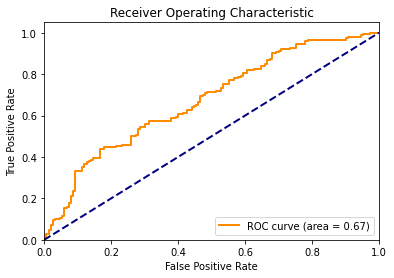

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5574 - loss: 0.6704
Validation Loss: 0.6536532044410706
Validation Accuracy: 0.5785714387893677
Test Loss: 0.651773880024751
Inference Time (seconds): 0.769885778427124
Test Accuracy: 0.6133333333333333
Confusion Matrix:
 [[125  25]
 [ 91  59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.83      0.68       150
           1       0.70      0.39      0.50       150

    accuracy                           0.61       300
   macro avg       0.64      0.61      0.59       300
weighted avg       0.64      0.61      0.59       300

ROC AUC Score: 0.6732444444444443
Metrics saved successfully


In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [88]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.6523 - loss: 0.6263 - val_accuracy: 0.5143 - val_loss: 0.7079
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.5939 - loss: 0.6532 - val_accuracy: 0.6143 - val_loss: 0.6590
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.6499 - loss: 0.6254 - val_accuracy: 0.5714 - val_loss: 0.6474
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.6538 - loss: 0.6236 - val_accuracy: 0.5929 - val_loss: 0.6431
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.6791 - loss: 0.5940 - val_accuracy: 0.6000 - val_loss: 0.6911
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.6906 - loss: 0.5860 - val_accuracy: 0.4929 - val_loss: 0.7192
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.6730 - loss: 0.6100 - val_accuracy: 0.5714 - val_loss: 0.6893
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.5101 - loss: 0.7107 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


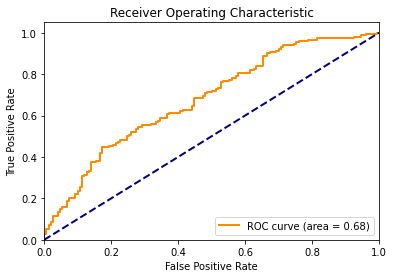

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5535 - loss: 0.6639
Validation Loss: 0.643085777759552
Validation Accuracy: 0.5928571224212646
Test Loss: 0.6425886178016662
Inference Time (seconds): 0.7763657569885254
Test Accuracy: 0.6266666666666667
Confusion Matrix:
 [[112  38]
 [ 74  76]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67       150
           1       0.67      0.51      0.58       150

    accuracy                           0.63       300
   macro avg       0.63      0.63      0.62       300
weighted avg       0.63      0.63      0.62       300

ROC AUC Score: 0.6785333333333333
Metrics saved successfully


In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [90]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.6281 - loss: 0.6220 - val_accuracy: 0.6286 - val_loss: 0.6577
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.6659 - loss: 0.6016 - val_accuracy: 0.5000 - val_loss: 0.7205
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6695 - loss: 0.5910 - val_accuracy: 0.6357 - val_loss: 0.6614
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.7084 - loss: 0.5720 - val_accuracy: 0.6429 - val_loss: 0.6419
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.7265 - loss: 0.5537 - val_accuracy: 0.6071 - val_loss: 0.6529
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.6904 - loss: 0.5876 - val_accuracy: 0.6286 - val_loss: 0.6463
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6558 - loss: 0.5879 - val_accuracy: 0.5857 - val_loss: 0.6789
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.7360 - loss: 0.5347 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


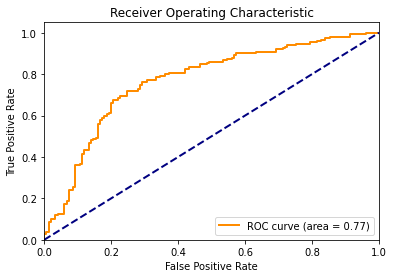

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6598 - loss: 0.6131
Validation Loss: 0.6135643720626831
Validation Accuracy: 0.6642857193946838
Test Loss: 0.6070110840598743
Inference Time (seconds): 0.7717618942260742
Test Accuracy: 0.6966666666666667
Confusion Matrix:
 [[125  25]
 [ 66  84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73       150
           1       0.77      0.56      0.65       150

    accuracy                           0.70       300
   macro avg       0.71      0.70      0.69       300
weighted avg       0.71      0.70      0.69       300

ROC AUC Score: 0.766888888888889
Metrics saved successfully


In [91]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")